# Import supporting package

In [1]:
import lmfit
import xarray as xr
import pandas as pd
import numpy as np
import copy

import glob

import xrft
import finufft

from uncertainties import ufloat
from uncertainties import unumpy as unp
from uncertainties import umath

from datetime import datetime

import matplotlib.pyplot as plt

#test
plt.rcParams['font.size'] = 18

from scipy.ndimage import gaussian_filter
import matplotlib as mpl
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)

from DataContainer.ReadData import read_hdf5_file, read_hdf5_global, read_hdf5_run_time, read_csv_file
from Analyser.ImagingAnalyser import ImageAnalyser
from Analyser.FitAnalyser import FitAnalyser
from Analyser.FitAnalyser import ThomasFermi2dModel, DensityProfileBEC2dModel, Polylog22dModel
from Analyser.FFTAnalyser import fft, ifft, fft_nutou
from ToolFunction.ToolFunction import *

import time

from ToolFunction.HomeMadeXarrayFunction import errorbar, dataarray_plot_errorbar
xr.plot.dataarray_plot.errorbar = errorbar
xr.plot.accessor.DataArrayPlotAccessor.errorbar = dataarray_plot_errorbar

imageAnalyser = ImageAnalyser()



In [19]:
# get center of thresholded image
def calc_thresh(data):
    shape = np.shape(data)
    thresh = np.zeros(shape)
    sigma = 0.4

    if len(shape) == 4:
        blurred = gaussian_filter(data, sigma=sigma)
        for i in range(0,shape[0]):
            for j in range(0, shape[1]):
                thresh[i,j] = np.where(blurred[i,j] < np.max(blurred[i,j])*0.3,0,1)

    elif len(shape) == 3:
        blurred = gaussian_filter(data, sigma=sigma)
        for i in range(0,shape[0]):
                thresh[i] = np.where(blurred[i] < np.max(blurred[i])*0.3,0,1)

    else:
        print("Shape of data is wrong, output is empty")

    return thresh

def calc_cen(thresh1):
    """
    returns array: [Y_center,X_center]
    """
    cen = np.zeros(2)
    (Y,X) = np.shape(thresh1)


    thresh1 = thresh1 /np.sum(thresh1)

    # marginal distributions
    dx = np.sum(thresh1, 0)
    dy = np.sum(thresh1, 1)

    # expected values
    cen[0] = np.sum(dx * np.arange(X))
    cen[1] = np.sum(dy * np.arange(Y))
    return cen

def calc_cen_bulk(thresh):
    """
    returns array in shape of input, containing array with [Y_center,X_center] for each image
    """
    shape = np.shape(thresh)
    cen = np.zeros((shape[0], shape[1], 2))
    for i in range(0, shape[0]):
        for j in range(0, shape[1]):
            cen[i,j] = calc_cen(thresh[i,j])
    return cen

def guess_BEC_width(thresh, center):
    """
    returns width of thresholded area along both axis through the center with shape of thresh and [X_width, Y_width] for each image
    """
    shape = np.shape(thresh)
    BEC_width_guess = np.zeros((shape[0], shape[1], 2))

    for i in range(0, shape[0]):
        for j in range(0, shape[1]):
            BEC_width_guess[i, j, 0] = np.sum(thresh[i, j, round(center[i,j,1]), :])
            BEC_width_guess[i, j, 1] = np.sum(thresh[i, j, :, round(center[i,j,0])])

    return BEC_width_guess



def gaussian(x, x0, sigma, A):
    return A * np.exp(-0.5 * (x-x0)**2 / sigma**2)

# def polylog(power, numerator, order = 15):
#
#     dataShape = numerator.shape
#     numerator = np.tile(numerator, (order, 1))
#     numerator = np.power(numerator.T, np.arange(1, order+1)).T
#
#     denominator = np.arange(1, order+1)
#     denominator = np.tile(denominator, (dataShape[0], 1))
#     denominator = denominator.T
#
#     data = numerator/ np.power(denominator, power)
#
#     return np.sum(data, axis=0)

def polylog_tab(pow, x):
    order = 100
    sum = 0
    for k in range(1,order):
        sum  += x ** k /k **pow
    return sum

x_int = np.linspace(0, 1.00001, 100000)

poly_tab = polylog_tab(2,x_int)



polylog_int = CubicSpline(x_int, poly_tab)

def thermal(x, x0, amp, sigma):
    res = np.exp(-0.5 * (x-x0)**2 / sigma**2)
    return amp/1.643 * polylog_int(res)

def Thomas_Fermi_1d(x, x0, amp, sigma):
    res = (1- ((x-x0)/sigma)**2)
    res = np.where(res > 0, res, 0)
    res = res**(3/2)
    return amp * res

def density_1d(x, x0_bec, x0_th, amp_bec, amp_th, sigma_bec, sigma_th):
    return thermal(x, x0_th, amp_th, sigma_th) + Thomas_Fermi_1d(x, x0_bec, amp_bec, sigma_bec)


def polylog(pow, x):
    order = 15
    sum = 0
    for k in range(1,order):
        sum  += x ** k /k **pow
    return sum


def ThomasFermi_2d(x, y=0.0, centerx=0.0, centery=0.0, amplitude=1.0, sigmax=1.0, sigmay=1.0):

    res = (1- ((x-centerx)/(sigmax))**2 - ((y-centery)/(sigmay))**2)
    res = np.where(res > 0, res, 0)
    res = res**(3/2)
    return amplitude * res
    # return amplitude * 5 / 2 / np.pi / max(tiny, sigmax * sigmay) * np.where(res > 0, res, 0)


    # return amplitude / 2 / np.pi / 1.20206 / max(tiny, sigmax * sigmay) * polylog(2, np.exp( -((x-centerx)**2/(2 * (sigmax)**2))-((y-centery)**2/( 2 * (sigmay)**2)) ))
# Set up table for polylog


def polylog2_2d(x, y=0.0, centerx=0.0, centery=0.0, amplitude=1.0, sigmax=1.0, sigmay=1.0):
    ## Approximation of the polylog function with 2D gaussian as argument. -> discribes the thermal part of the cloud
    return amplitude/1.643  * polylog_int(np.exp( -((x-centerx)**2/(2 * sigmax**2))-((y-centery)**2/( 2 * sigmay**2)) ))



def density_profile_BEC_2d(x, y=0.0, amp_bec=1.0, amp_th=1.0, x0_bec=0.0, y0_bec=0.0, x0_th=0.0, y0_th=0.0,
                           sigmax_bec=1.0, sigmay_bec=1.0, sigma_th=1.0):
    return ThomasFermi_2d(x=x, y=y, centerx=x0_bec, centery=y0_bec,
                          amplitude=amp_bec, sigmax=sigmax_bec, sigmay=sigmay_bec
                          ) + polylog2_2d(x=x, y=y, centerx=x0_th, centery=y0_th,
                                          amplitude=amp_th, sigmax=sigma_th,sigmay=sigma_th)

def cond_frac(results):
    bval = results.best_values
    tf_fit = ThomasFermi_2d(X,Y,centerx=bval['x0_bec'], centery=bval['y0_bec'], amplitude=bval['amp_bec'], sigmax=bval['sigmax_bec'], sigmay=bval['sigmay_bec'])
    N_bec = np.sum(tf_fit)
    fit = fit = density_profile_BEC_2d(X,Y, **bval)
    N_ges = np.sum(fit)
    return N_bec/N_ges

def print_bval(res_s):
    keys = res_s.best_values.keys()
    bval = res_s.best_values
    init = res_s.init_params

    for item in keys:
        print(f'{item}: {bval[item]:.3f}, (init = {init[item].value:.3f}), bounds = [{init[item].min:.2f} : {init[item].max :.2f}] ')
    print('')

def print_bval_bulk(res_):
    shape = np.shape(res_)
    if len(shape) == 2:
        for i in range(shape[0]):
            for j in range(shape[1]):
                print(f'image: {i}, {j}')
                print_bval(res_[i][j])

    if len(shape) == 1:
        for i in range(shape[0]):
            print(f'image: {i}')
            print_bval(res_[i])


In [3]:
# import data
img_dir = '//DyLabNAS/Data/'
SequenceName = "Evaporative_Cooling" + "/"
folderPath = img_dir + SequenceName + '2023/04/24'# get_date()


shotNum = "0009"
filePath = folderPath + "/" + shotNum + "/2023-04-24_0009_Evaporative_Cooling_*0.h5"



In [4]:

dataSet = read_hdf5_file(filePath, "images/MOT_3D_Camera/in_situ_absorption")
# flip the x and y axis
dataSet = swap_xy(dataSet)

# get the scan axis name of the shot
scanAxis = get_scanAxis(dataSet)

# calculate the absorption imaging
dataSet = imageAnalyser.get_absorption_images(dataSet)

OD = dataSet["OD"]

OD_np = OD.to_numpy()

C:\Users\Jianshun Gao\PycharmProjects\analyseScript\venv\lib\site-packages\dask\core.py:121: RuntimeWarning: divide by zero encountered in log
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\Jianshun Gao\PycharmProjects\analyseScript\venv\lib\site-packages\dask\core.py:121: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


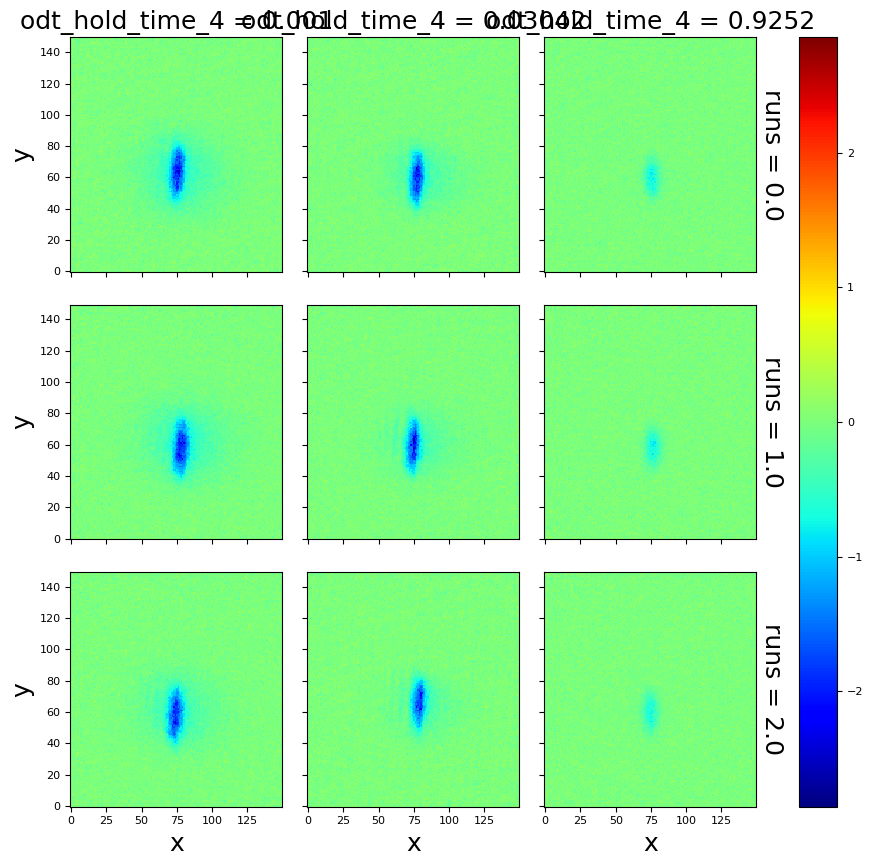

In [37]:
imageAnalyser.center = (960, 890)
imageAnalyser.span = (150, 150)
imageAnalyser.fraction = (0.1, 0.1)

plot_data = np.log((dataSet["atoms"] - dataSet["dark"])/(dataSet["background"] - dataSet["dark"]))
dataSet_cropOD = imageAnalyser.crop_image(plot_data)
dataSet_cropOD = imageAnalyser.substract_offset(dataSet_cropOD).load()
#cropOD = dataSet_cropOD.to_numpy()


dataSet_cropOD.plot.pcolormesh(cmap='jet', col=scanAxis[0], row=scanAxis[1])
plt.show()

In [5]:
data = OD_np
cut_width = 200
thresh = calc_thresh(data)
center = calc_cen_bulk(thresh)

shape = np.shape(data)
cropOD = np.zeros((shape[0], shape[1], cut_width, cut_width))
blurred = gaussian_filter(data, sigma=1)

for i in range(0,shape[0]):
    for j in range(0, shape[1]):
        amax = np.argmax(blurred[i,j])

        center[i,j] = np.unravel_index(amax, (shape[2], shape[3]))
        print(center[i,j])
        print(np.max(data[i,j]))
        print(data[i,j, round(center[i,j,0]), round(center[i,j,1]) ])
        cropOD[i,j] = data[i,j, round(center[i,j,0]-cut_width/2):round(center[i,j,0]+cut_width/2), round(center[i,j,1]-cut_width/2):round(center[i,j,1]+cut_width/2)]

thresh = calc_thresh(cropOD)
center = calc_cen_bulk(thresh)
# print(center)
BEC_width_guess = guess_BEC_width(thresh, center)


[879. 961.]
2.8134107167600364
2.8134107167600364
[878. 961.]
2.4849066497880004
1.890850371872286
[876. 961.]
2.583997552432231
1.6863989535702288
[878. 961.]
2.8526314299133175
1.9859154836690123
[877. 961.]
2.691243082785829
2.0794415416798357
[876. 961.]
2.2192034840549946
1.5723966407537513
[877. 961.]
0.916290731874155
0.7817005779013904
[876. 961.]
1.3862943611198906
0.6539264674066639
[876. 961.]
0.916290731874155
0.6131044728864089


In [226]:
print(BEC_width_guess)


[[[19. 15.]
  [19. 18.]
  [24. 20.]
  [26. 23.]
  [26. 19.]
  [28. 23.]
  [26. 22.]
  [26. 25.]
  [25. 22.]
  [25. 20.]
  [30. 25.]]

 [[ 5.  3.]
  [ 9.  5.]
  [ 7.  9.]
  [10.  4.]
  [15. 13.]
  [22. 17.]
  [15. 15.]
  [ 7.  4.]
  [13. 12.]
  [19. 15.]
  [14. 12.]]]


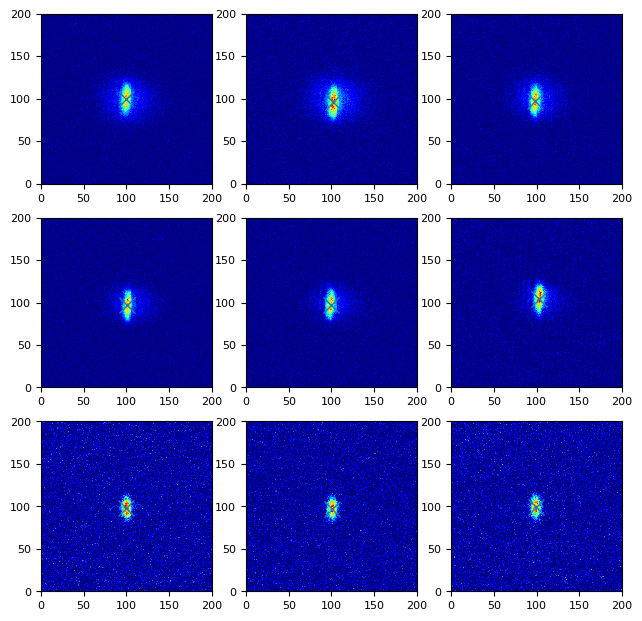

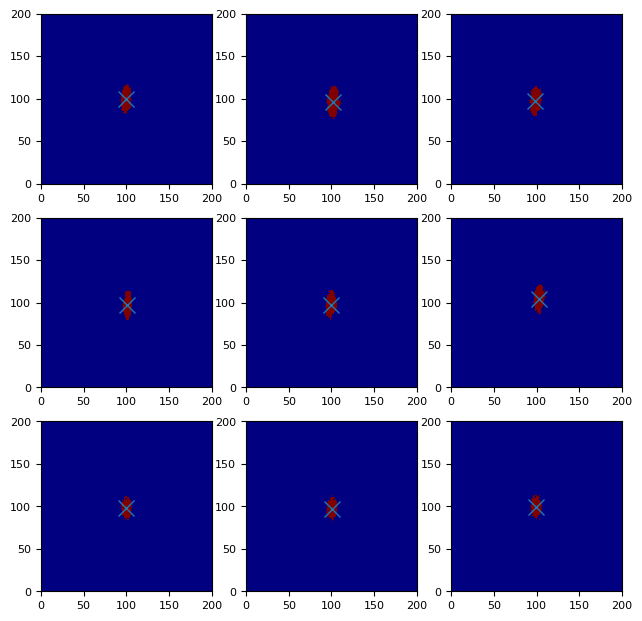

In [12]:
fsize = (shape[0]*2.5, shape[1]*2.5)
fig, ax = plt.subplots(shape[0],shape[1], figsize=fsize)

for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        ax[i,j].pcolormesh(cropOD[i,j], cmap='jet',vmin=0,vmax=np.max(cropOD[i,j]),shading='auto')
        ax[i,j].plot(center[i,j,0], center[i,j,1], markersize=12, marker='x')
plt.show()

fig, ax = plt.subplots(shape[0],shape[1], figsize=fsize)

for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        ax[i,j].pcolormesh(thresh[i,j], cmap='jet')
        ax[i,j].plot(center[i,j,0], center[i,j,1], markersize=12, marker='x')
plt.show()


In [20]:
# from opencv import moments
start = time.time()
shape = np.shape(cropOD)
sigma = 0.4
blurred = gaussian_filter(cropOD, sigma=sigma)

thresh = np.zeros(shape)
for i in range(0,shape[0]):
    for j in range(0, shape[1]):
        thresh[i,j] = np.where(blurred[i,j] < np.max(blurred[i,j])*0.5,0,1)

center = calc_cen_bulk(thresh)

BEC_width_guess = guess_BEC_width(thresh, center)

X_guess_og = np.zeros((shape[0], shape[1], shape[3]))
# Y_guess_og = np.zeros((shape[0], shape[1], shape[2]))

for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        X_guess_og[i,j] = np.sum(cropOD[i,j,round(center[i,j,1] - BEC_width_guess[i,j,1]/2) : round(center[i,j,1] + BEC_width_guess[i,j,1]/2) , :], 0) / len(cropOD[i,j,round(center[i,j,1] - BEC_width_guess[i,j,1]/2) : round(center[i,j,1] + BEC_width_guess[i,j,1]/2),0])

        # Y_guess_og[i,j] = np.sum(cropOD[i,j, :, round(center[i,j,0] - BEC_width_guess[i,j,0]/2) : round(center[i,j,0] + BEC_width_guess[i,j,0]/2)], 1) / len(cropOD[i,j,0,round(center[i,j,0] - BEC_width_guess[i,j,0]/2) : round(center[i,j,0] + BEC_width_guess[i,j,0]/2)])

#[nr images x, nr images y, X / Y, center / sigma]
x = np.linspace(0,shape[3],shape[3])
y = np.linspace(0,shape[2], shape[2])

popt = np.zeros((shape[0], shape[1], 6))

p0 = np.ones((shape[0], shape[1], 6))

max_val = np.zeros((shape[0], shape[1]))

for i in range(0, shape[0]):
    max_val[i] = np.ndarray.max(X_guess_og[i], axis=1)

# Fitting x without math constr
fitmodel = lmfit.Model(density_1d,independent_vars=['x'])

result_x = []

for i in range(0, shape[0]):
    temp_res = []
    for j in range(0, shape[1]):
        t1 = time.time()
        params = lmfit.Parameters()
        params.add_many(
            ('x0_bec', center[i,j,0], True,0, 200),
            ('x0_th',center[i,j,0], True,0, 200),
            ('amp_bec', 0.7 * max_val[i,j], True, 0, 1.3 * np.max(X_guess_og[i,j])),
            ('amp_th', 0.3 * max_val[i,j], True, 0, 1.3 * np.max(X_guess_og[i,j])),
            ('deltax', 70, True, 0,150),
            ('sigma_bec',BEC_width_guess[i,j,0]/1.22, True, 0, 50)
        )
        params.add('sigma_th', 3*BEC_width_guess[i,j,0], min=0, expr=f'0.632*sigma_bec + 0.518*deltax')

        # params.add('sigma_th', 3*BEC_width_guess[i,j,0], True, min=0,max=150)
        t2 = time.time()
        res = fitmodel.fit(X_guess_og[i,j], x=x, params=params)
        t3 = time.time()
        temp_res.append(res)
        t4 = time.time()
        # print(t2 - t1)
        # print(t3 - t2)
        # print(t4 - t3)
        # print("")
        lmfit.report_fit(res)

        print()
    result_x.append(temp_res)
stop = time.time()

print(f'total time: {(stop-start)*1e3} ms')

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 36
    # data points      = 200
    # variables        = 6
    chi-square         = 0.12293367
    reduced chi-square = 6.3368e-04
    Akaike info crit   = -1466.88554
    Bayesian info crit = -1447.09564
    R-squared          = 0.99462760
[[Variables]]
    x0_bec:     99.8647761 +/- 0.03787568 (0.04%) (init = 99.66897)
    x0_th:      101.694894 +/- 0.22678895 (0.22%) (init = 99.66897)
    amp_bec:    1.20335718 +/- 0.01500965 (1.25%) (init = 1.275821)
    amp_th:     0.55422943 +/- 0.01054007 (1.90%) (init = 0.5467806)
    deltax:     30.2589309 +/- 0.64613907 (2.14%) (init = 70)
    sigma_bec:  6.96569008 +/- 0.06993060 (1.00%) (init = 5.737705)
    sigma_th:   20.0764423 +/- 0.34664172 (1.73%) == '0.632*sigma_bec + 0.518*deltax'
[[Correlations]] (unreported correlations are < 0.100)
    C(amp_th, deltax)    = -0.7374
    C(amp_bec, amp_th)   = -0.6500
    C(amp_bec, deltax)   = +0.5160
    C(amp_th, sigma

In [21]:
# from opencv import moments
start = time.time()

shape = np.shape(cropOD)
thresh = calc_thresh(cropOD)
center = calc_cen_bulk(thresh)
# print(center)
BEC_width_guess = guess_BEC_width(thresh, center)

X_guess_og = np.zeros((shape[0], shape[1], shape[3]))
# Y_guess_og = np.zeros((shape[0], shape[1], shape[2]))

for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        X_guess_og[i,j] = np.sum(cropOD[i,j,round(center[i,j,1] - BEC_width_guess[i,j,1]/2) : round(center[i,j,1] + BEC_width_guess[i,j,1]/2) , :], 0) / len(cropOD[i,j,round(center[i,j,1] - BEC_width_guess[i,j,1]/2) : round(center[i,j,1] + BEC_width_guess[i,j,1]/2),0])

        # Y_guess_og[i,j] = np.sum(cropOD[i,j, :, round(center[i,j,0] - BEC_width_guess[i,j,0]/2) : round(center[i,j,0] + BEC_width_guess[i,j,0]/2)], 1) / len(cropOD[i,j,0,round(center[i,j,0] - BEC_width_guess[i,j,0]/2) : round(center[i,j,0] + BEC_width_guess[i,j,0]/2)])

#[nr images x, nr images y, X / Y, center / sigma]
x = np.linspace(0,shape[3],shape[3])
y = np.linspace(0,shape[2], shape[2])

popt = np.zeros((shape[0], shape[1], 6))

p0 = np.ones((shape[0], shape[1], 6))

max_val = np.zeros((shape[0], shape[1]))

for i in range(0, shape[0]):
    max_val[i] = np.ndarray.max(X_guess_og[i], axis=1)

# Fitting x without math constr
fitmodel = lmfit.Model(density_1d,independent_vars=['x'])

result_x = []

for i in range(0, shape[0]):
    temp_res = []
    for j in range(0, shape[1]):
        t1 = time.time()
        params = lmfit.Parameters()
        params.add_many(
            ('x0_bec', center[i,j,0], True,0, 200),
            ('x0_th',center[i,j,0], True,0, 200),
            ('amp_bec', 0.7 * max_val[i,j], True, 0, 1.3 * np.max(X_guess_og[i,j])),
            ('amp_th', 0.3 * max_val[i,j], True, 0, 1.3 * np.max(X_guess_og[i,j])),
            ('deltax', 3*BEC_width_guess[i,j,0], True, 0,cut_width),
            # ('sigma_bec',BEC_width_guess[i,j,0]/1.22, True, 0, 50)
            ('sigma_bec',BEC_width_guess[i,j,0]/1.22, True, 0, 50)
        )
        params.add('sigma_th', 3*BEC_width_guess[i,j,0], min=0, expr=f'0.632*sigma_bec + 0.518*deltax')

        # params.add('sigma_th', 3*BEC_width_guess[i,j,0], True, min=0,max=150)
        t2 = time.time()
        res = fitmodel.fit(X_guess_og[i,j], x=x, params=params)
        t3 = time.time()
        temp_res.append(res)
        t4 = time.time()
        # print(t2 - t1)
        # print(t3 - t2)
        # print(t4 - t3)
        # print("")
        print(f'image {i}, {j}')
        lmfit.report_fit(res)
        print()

        print()
    result_x.append(temp_res)
stop = time.time()

print(f'total time: {(stop-start)*1e3} ms')

image 0, 0
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 57
    # data points      = 200
    # variables        = 6
    chi-square         = 0.09272930
    reduced chi-square = 4.7799e-04
    Akaike info crit   = -1523.27764
    Bayesian info crit = -1503.48773
    R-squared          = 0.99495034
[[Variables]]
    x0_bec:     99.8354426 +/- 0.03769284 (0.04%) (init = 99.387)
    x0_th:      101.629651 +/- 0.21352060 (0.21%) (init = 99.387)
    amp_bec:    1.05090465 +/- 0.01302118 (1.24%) (init = 1.130844)
    amp_th:     0.51118368 +/- 0.00913050 (1.79%) (init = 0.4846473)
    deltax:     30.3446150 +/- 0.60807796 (2.00%) (init = 39)
    sigma_bec:  6.96828716 +/- 0.06963029 (1.00%) (init = 10.65574)
    sigma_th:   20.1224681 +/- 0.32667975 (1.62%) == '0.632*sigma_bec + 0.518*deltax'
[[Correlations]] (unreported correlations are < 0.100)
    C(amp_th, deltax)    = -0.7350
    C(amp_bec, amp_th)   = -0.6490
    C(amp_bec, deltax)   = +0.5165
    C(amp_th

In [241]:
for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        print(result_x[i][j].best_values)

{'x0_bec': 119.96802214244894, 'x0_th': 127.63326165397993, 'amp_bec': 0.010428258179001615, 'amp_th': 0.09970108267412295, 'sigma_bec': 11.583362968593697, 'sigma_th': 38.31090265345486}
{'x0_bec': 125.05526628410517, 'x0_th': 125.00471649795092, 'amp_bec': 0.17310779365126494, 'amp_th': 0.1720820730247045, 'sigma_bec': 15.656355803721866, 'sigma_th': 27.064591004484093}
{'x0_bec': 124.87559149065213, 'x0_th': 124.75161622610302, 'amp_bec': 0.29524310149188965, 'amp_th': 0.1743190061268859, 'sigma_bec': 18.491463993335323, 'sigma_th': 26.355871715002863}
{'x0_bec': 125.0087031646933, 'x0_th': 124.76274722033101, 'amp_bec': 0.33449244741806405, 'amp_th': 0.2075912078840139, 'sigma_bec': 20.02281507393876, 'sigma_th': 21.82533112738463}
{'x0_bec': 125.14911780036935, 'x0_th': 125.19236477144689, 'amp_bec': 0.43441287165926823, 'amp_th': 0.2269965135606747, 'sigma_bec': 21.735511537553013, 'sigma_th': 19.6332649156627}
{'x0_bec': 125.19706330180884, 'x0_th': 124.78639501711406, 'amp_bec'

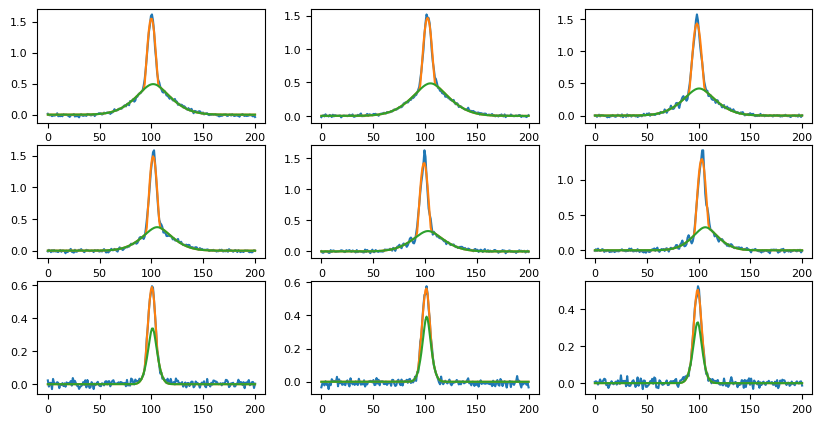

In [8]:
fsize= (10,5)
fig, ax = plt.subplots(shape[0],shape[1],figsize=fsize)
for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        #lab = f"A$_{{BEC}}$ = {popt[i,j,0]:.1f} \n A$_{{th}}$ = {popt[i,j,1]:.1f} "
        bval = result_x[i][j].best_values
        ax[i,j].plot(x, X_guess_og[i,j])
        ax[i,j].plot(x, density_1d(x, **result_x[i][j].best_values))
        ax[i,j].plot(x, thermal(x, bval['x0_th'], bval['amp_th'], bval['sigma_th']))


plt.show()

## 2D Fit without mathematical constraint

In [33]:

result = []
times = []
x = np.linspace(0,shape[3],cut_width)
y = np.linspace(0,shape[2], cut_width)

for i in range(0,shape[0]):
    temp_res_arr = []
    for j in range(0,shape[1]):
        print()
        print(f'image {i},{j}')
        data = cropOD[i,j]
        fitModel = lmfit.Model(density_profile_BEC_2d, independent_vars=['x','y'])
        #fitModel.set_param_hint('deltax', value=5)

        bval_1d = result_x[i][j].best_values
        S = np.max(blurred[i,j])/(bval_1d['amp_bec'] + bval_1d['amp_th'])

        params = lmfit.Parameters()
        #print(bval['sigma_th'])
        params.add_many(
            ('amp_bec', S * bval_1d['amp_bec'], True, 0, 1.3 * np.max(data)),
            ('amp_th',S * bval_1d['amp_th'], True, 0, 1.3 * np.max(data)),
            ('x0_bec',center[i,j,0], True, center[i,j,0] -10, center[i,j,0] + 10),
            ('y0_bec',center[i,j,1], True, center[i,j,1] -10, center[i,j,1] + 10),
            ('x0_th',center[i,j,0], True, center[i,j,0] -10, center[i,j,0] + 10),
            ('y0_th',center[i,j,1], True, center[i,j,1] -10, center[i,j,1] + 10),
            ('sigmax_bec',bval_1d['sigma_bec'], True, 0, 50),
            ('sigmay_bec',bval_1d['sigma_bec'], True, 0, 50),
            ('sigma_th',bval_1d['sigma_th'], True, 0, cut_width)
        )

        X,Y = np.meshgrid(x, y)
        X_1d = X.flatten()
        Y_1d = Y.flatten()

        data1d = data.flatten()
        start = time.time()
        res = fitModel.fit(data1d, x=X_1d, y=Y_1d, params=params)
        stop = time.time()


        # Check if there is an thermal part
        bval = res.best_values
        sigma_cut = max_val(bval['sigmay_bec'], bval['sigmax_bec'])
        tf_fit = ThomasFermi_2d(X,Y,centerx=bval['x0_bec'], centery=bval['y0_bec'], amplitude=bval['amp_bec'], sigmax=bval['sigmax_bec'], sigmay=bval['sigmay_bec'])
        tf_fit_2 = ThomasFermi_2d(X,Y,centerx=bval['x0_bec'], centery=bval['y0_bec'], amplitude=bval['amp_bec'], sigmax=1.5 * sigma_cut, sigmay=1.5*sigma_cut)


        mask = np.where(tf_fit > 0, np.nan, data)
        #mask[i,j] = gaussian_filter(mask[i,j], sigma = 0.4)
        mask = np.where(tf_fit_2 > 0, mask, np.nan)

        check_value = np.nansum(mask)

        print(stop-start)

        # if (check_value < 45) or ((check_value > 10000) and (bval['sigma_th'] < min(bval['sigmax_bec'], bval['sigmay_bec']))):
        #check_value = 200
        if check_value < 45:
            print('No thermal part detected, performing fit without thermal function')
            # if check_value > 200:
            #     print('Sigma Thermal smaller than BEC, but still strong part around masked region --> BEC guessed wrong')

            params = lmfit.Parameters()
            #print(bval['sigma_th'])
            params.add_many(
                ('amp_bec', S * bval_1d['amp_bec'], True, 0, 1.3 * np.max(data)),
                ('amp_th',0, False, 0, 1.3 * np.max(data)),
                ('x0_bec',center[i,j,0], True, center[i,j,0] -10, center[i,j,0] + 10),
                ('y0_bec',center[i,j,1], True, center[i,j,1] - 10, center[i,j,1] + 10),
                ('x0_th', 1, False, 0, 150),
                ('y0_th', 1, False, 0, 150),
                ('sigmax_bec',bval_1d['sigma_bec'], True, 0, 50),
                ('sigmay_bec',BEC_width_guess[i,j,1], True, 0, 50),
                ('sigma_th',bval_1d['sigma_th'], False, 0, 50)
            )

            start2 = time.time()
            res = fitModel.fit(data1d, x=X_1d, y=Y_1d, params=params)
            stop2 = time.time()

            print(stop2-start2)
            print('')
        stop2 = time.time()



        times.append(stop2-start)
        temp_res_arr.append(res)
    result.append(temp_res_arr)
times = np.array(times)
print(f"fitting time = {np.mean(times)} +- {np.std(times, ddof=1)}")
print(times)




image 0,0
0.43511366844177246

image 0,1
0.39717936515808105

image 0,2
0.4489865303039551

image 1,0
0.487781286239624

image 1,1
0.7651829719543457

image 1,2
1.0349419116973877

image 2,0
0.5242712497711182
No thermal part detected, performing fit without thermal function
0.11019134521484375


image 2,1
0.34081077575683594
No thermal part detected, performing fit without thermal function
0.15068721771240234


image 2,2
0.2700233459472656
No thermal part detected, performing fit without thermal function
0.1531531810760498

fitting time = 0.5739162498050265 +- 0.2142232056665018
[0.43713617 0.3991735  0.4509809  0.48880529 0.79310822 1.03793383
 0.63744998 0.49448943 0.42616892]


In [17]:

result = []
result_1 = []
times = []
x = np.linspace(0,shape[3],cut_width)
y = np.linspace(0,shape[2], cut_width)

for i in range(0,shape[0]):
    temp_res_arr = []
    temp_res_arr_1 = []
    for j in range(0,shape[1]):
        print()
        print(f'image {i},{j}')
        data = cropOD[i,j]
        fitModel = lmfit.Model(density_profile_BEC_2d, independent_vars=['x','y'])
        #fitModel.set_param_hint('deltax', value=5)

        bval_1d = result_x[i][j].best_values
        S = np.max(gaussian_filter(data, sigma=1))/(bval_1d['amp_bec'] + bval_1d['amp_th'])
        params = lmfit.Parameters()
        #print(bval['sigma_th'])
        do_fit_2 = True
        if bval_1d['amp_th']/bval_1d['amp_bec'] > 4:
            print('Image seems to be purely thermal (guessed from 1d fit amplitude)')
            do_fit_2 = False
            params.add_many(
                ('amp_bec', 0, False, 0, 1.3 * np.max(data)),
                ('amp_th',S * bval_1d['amp_th'], True, 0, 1.3 * np.max(data)),
                ('x0_bec',1, False),
                ('y0_bec',1, False),
                ('x0_th',center[i,j,0], True, center[i,j,0] -10, center[i,j,0] + 10),
                ('y0_th',center[i,j,1], True, center[i,j,1] -10, center[i,j,1] + 10),
                ('sigmax_bec', 1, False),
                ('sigmay_bec', 1, False),
                ('sigma_th',bval_1d['sigma_th'], True, 0, cut_width)
            )

        elif bval_1d['amp_bec']/bval_1d['amp_th'] > 10:
            print('Image seems to be pure BEC (guessed from 1d fit amplitude)')
            do_fit_2 = False
            params.add_many(
                ('amp_bec', S * bval_1d['amp_bec'], True, 0, 1.3 * np.max(data)),
                ('amp_th',0, False),
                ('x0_bec',center[i,j,0], True, center[i,j,0] -10, center[i,j,0] + 10),
                ('y0_bec',center[i,j,1], True, center[i,j,1] - 10, center[i,j,1] + 10),
                ('x0_th', 1, False),
                ('y0_th', 1, False),
                ('sigmax_bec',bval_1d['sigma_bec'], True, 0, 2/1.22 * BEC_width_guess[i,j,0]),
                ('sigmay_bec',BEC_width_guess[i,j,1]/1.22, True, 0, 2/1.22 * BEC_width_guess[i,j,0]),
                ('sigma_th',bval_1d['sigma_th'], False, 0, 50)
            )



        else:
            params.add_many(
                ('amp_bec', S * bval_1d['amp_bec'], True, 0, 1.3 * np.max(data)),
                ('amp_th',S * bval_1d['amp_th'], True, 0, 1.3 * np.max(data)),
                ('x0_bec',center[i,j,0], True, center[i,j,0] -10, center[i,j,0] + 10),
                ('y0_bec',center[i,j,1], True, center[i,j,1] -10, center[i,j,1] + 10),
                ('x0_th',center[i,j,0], True, center[i,j,0] -10, center[i,j,0] + 10),
                ('y0_th',center[i,j,1], True, center[i,j,1] -10, center[i,j,1] + 10),
                ('sigmax_bec',bval_1d['sigma_bec'], True, 0, 2/1.22 * BEC_width_guess[i,j,0]),
                ('sigmay_bec',BEC_width_guess[i,j,1]/1.22, True, 0, 2/1.22 * BEC_width_guess[i,j,1]),
                ('sigma_th',bval_1d['sigma_th'], True, 0, cut_width)
            )

        X,Y = np.meshgrid(x, y)
        X_1d = X.flatten()
        Y_1d = Y.flatten()

        data1d = data.flatten()
        start = time.time()
        res = fitModel.fit(data1d, x=X_1d, y=Y_1d, params=params)
        stop = time.time()
        temp_res_arr_1.append(res)


        # Check if there is an thermal part
        bval = res.best_values
        sigma_cut = max(bval['sigmay_bec'], bval['sigmax_bec'])
        tf_fit = ThomasFermi_2d(X,Y,centerx=bval['x0_bec'], centery=bval['y0_bec'], amplitude=bval['amp_bec'], sigmax=bval['sigmax_bec'], sigmay=bval['sigmay_bec'])
        tf_fit_2 = ThomasFermi_2d(X,Y,centerx=bval['x0_bec'], centery=bval['y0_bec'], amplitude=bval['amp_bec'], sigmax=1.5 * sigma_cut, sigmay=1.5*sigma_cut)


        mask = np.where(tf_fit > 0, np.nan, data)
        #mask[i,j] = gaussian_filter(mask[i,j], sigma = 0.4)
        mask = np.where(tf_fit_2 > 0, mask, np.nan)

        check_value = np.nansum(mask)

        print(f'time 1st fit: {stop-start :.3f} s')

        # if (check_value < 45) or ((check_value > 10000) and (bval['sigma_th'] < min(bval['sigmax_bec'], bval['sigmay_bec']))):
        # check_value = 200

        if check_value < 45 and do_fit_2:
            print('No thermal part detected, performing fit without thermal function')
            # if check_value > 200:
            #     print('Sigma Thermal smaller than BEC, but still strong part around masked region --> BEC guessed wrong')

            params = lmfit.Parameters()
            #print(bval['sigma_th'])
            params.add_many(
                ('amp_bec', S * bval_1d['amp_bec'], True, 0, 1.3 * np.max(data)),
                ('amp_th',0, False),
                ('x0_bec',center[i,j,0], True, center[i,j,0] -10, center[i,j,0] + 10),
                ('y0_bec',center[i,j,1], True, center[i,j,1] - 10, center[i,j,1] + 10),
                ('x0_th', 1, False),
                ('y0_th', 1, False),
                ('sigmax_bec',bval_1d['sigma_bec'], True, 0, 2/1.22 * BEC_width_guess[i,j,0]),
                ('sigmay_bec',BEC_width_guess[i,j,1]/1.22, True, 0, 2/1.22 * BEC_width_guess[i,j,0]),
                ('sigma_th',bval_1d['sigma_th'], False, 0, 50)
            )

            start2 = time.time()
            res = fitModel.fit(data1d, x=X_1d, y=Y_1d, params=params)
            stop2 = time.time()

            print(f'time pure bec fit: {stop2-start2 :.3f} s')
            print('')
        stop2 = time.time()



        times.append(stop2-start)
        temp_res_arr.append(res)
    result_1.append(temp_res_arr_1)
    result.append(temp_res_arr)
times = np.array(times)
print(f"fitting time = {np.mean(times):.3f} +- {np.std(times, ddof=1):.3f}")
print(f"max fitting time = {np.max(times) :.3f}s")
print(times)




image 0,0
time 1st fit: 0.336 s

image 0,1
time 1st fit: 0.412 s

image 0,2
time 1st fit: 0.275 s

image 1,0
time 1st fit: 0.220 s

image 1,1
time 1st fit: 0.267 s

image 1,2
time 1st fit: 0.330 s

image 2,0
time 1st fit: 0.496 s
No thermal part detected, performing fit without thermal function
time pure bec fit: 0.320 s


image 2,1
time 1st fit: 0.220 s
No thermal part detected, performing fit without thermal function
time pure bec fit: 0.228 s


image 2,2
time 1st fit: 0.194 s
No thermal part detected, performing fit without thermal function
time pure bec fit: 0.173 s

fitting time = 0.388 +- 0.177
max fitting time = 0.819s
[0.33971286 0.41459203 0.27741361 0.22098398 0.26939559 0.33163404
 0.81916142 0.45096374 0.3694396 ]


## Plotting

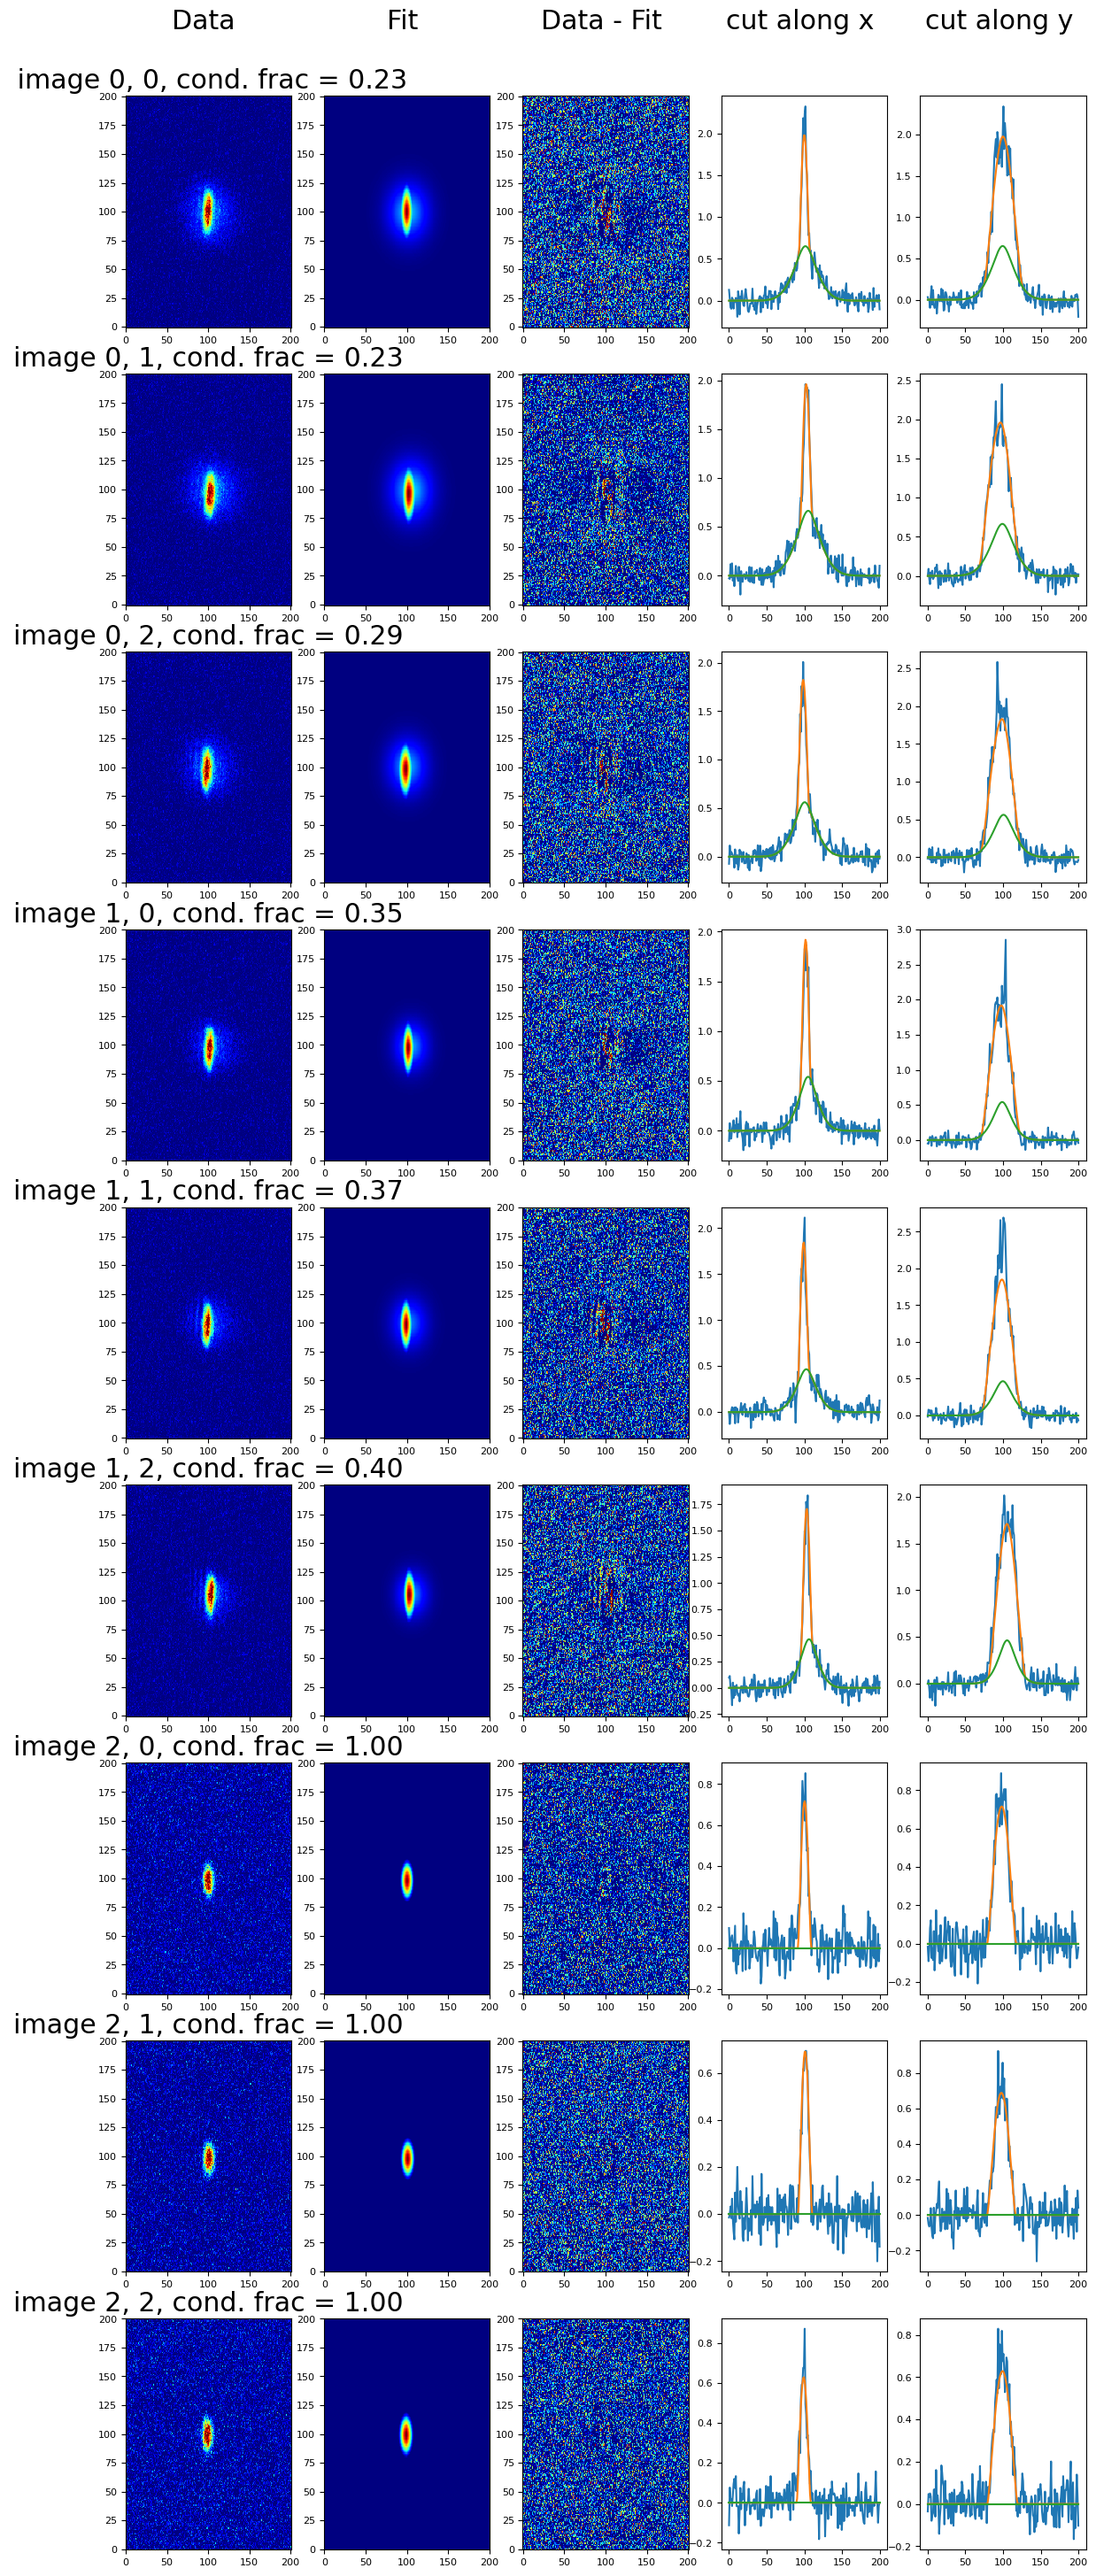

In [18]:
fig, axs = plt.subplots(shape[0] * shape[1], 5, figsize=(14, 4 * shape[0] * shape[1]),dpi = 100)

ii = 0
for i in range(0,shape[0]):

    for j in range(0,shape[1]):
        axs[ii,0].set_title(f'image {i}, {j}, cond. frac = {cond_frac(result[i][j]) :.2f}')
        lmfit.fit_report(result[i][j])
        bval = result[i][j].best_values
        fit = density_profile_BEC_2d(X,Y, **bval)
        vmax = np.max(fit)



        ax = axs[ii,0]
        ax.pcolormesh(X, Y, cropOD[i,j], vmin=0, vmax=vmax, cmap='jet', shading='auto')
        #plt.colorbar(art, ax=ax, label='z')


        # Plot gaussian 2d Fit + legend including Width parameters
        ax = axs[ii,1]

        ax.pcolormesh(X, Y, fit, vmin=0, vmax=vmax, cmap='jet', shading='auto')
        #plt.colorbar(art, ax=ax, label='z')

        ax = axs[ii,2]

        ax.pcolormesh(X, Y, fit-cropOD[i,j], vmin=0, vmax=0.2, cmap='jet', shading='auto')


        ax = axs[ii,3]

        ax.plot(x, cropOD[i,j, round(center[i,j,1]), :])
        ax.plot(x, fit[round(center[i,j,1]), :])
        ax.plot(x, thermal(x, bval['x0_th'], bval['amp_th'], bval['sigma_th']))

        ax = axs[ii,4]

        ax.plot(y, cropOD[i,j, :, round(center[i,j,0])])
        ax.plot(y, fit[:, round(center[i,j,0])])
        ax.plot(x, thermal(y, bval['y0_th'], bval['amp_th'], bval['sigma_th']))


        ii += 1

axs[0,0].set_title(f'Data \n \n image {0}, {0}, cond. frac = {cond_frac(result[0][0]) :.2f}')
axs[0,1].set_title('Fit \n \n')
axs[0,2].set_title('Data - Fit \n \n')
axs[0,3].set_title('cut along x \n \n')
axs[0,4].set_title('cut along y \n \n')



plt.show()

In [79]:

for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        sx = result[i][j].best_values['sigmax_bec']
        sy = result[i][j].best_values['sigmay_bec']
        s_th = result[i][j].best_values['sigma_th']

        print(f'image {i}, {j}')
        print(min(sx*1.22, sy*1.22))
        print(f'FWHM_x BEC: { sx*1.22:.2f}, FWHM_x thermal: { s_th*1.93:.2f}')
        print(f'FWHM_y BEC: { sy*1.22:.2f}')
        print(f'Ratio fwhm_th/fwhm_bec: { 1/min(sx,sy)/1.22 * s_th *1.93 :.2f}')
        print('')

image 0, 0
8.742963672373875
FWHM_x BEC: 8.74, FWHM_x thermal: 34.83
FWHM_y BEC: 31.25
Ratio fwhm_th/fwhm_bec: 3.98

image 0, 1
9.592979643136657
FWHM_x BEC: 9.59, FWHM_x thermal: 36.62
FWHM_y BEC: 31.81
Ratio fwhm_th/fwhm_bec: 3.82

image 0, 2
9.908906632618283
FWHM_x BEC: 9.91, FWHM_x thermal: 33.38
FWHM_y BEC: 31.46
Ratio fwhm_th/fwhm_bec: 3.37

image 1, 0
8.451865807002145
FWHM_x BEC: 8.45, FWHM_x thermal: 29.08
FWHM_y BEC: 31.26
Ratio fwhm_th/fwhm_bec: 3.44

image 1, 1
8.984709061577554
FWHM_x BEC: 8.98, FWHM_x thermal: 30.65
FWHM_y BEC: 30.46
Ratio fwhm_th/fwhm_bec: 3.41

image 1, 2
9.13705851096225
FWHM_x BEC: 9.14, FWHM_x thermal: 26.96
FWHM_y BEC: 30.05
Ratio fwhm_th/fwhm_bec: 2.95

image 2, 0
9.424910150431879
FWHM_x BEC: 9.42, FWHM_x thermal: 20.56
FWHM_y BEC: 23.24
Ratio fwhm_th/fwhm_bec: 2.18

image 2, 1
9.984465643230875
FWHM_x BEC: 9.98, FWHM_x thermal: 13.17
FWHM_y BEC: 25.10
Ratio fwhm_th/fwhm_bec: 1.32

image 2, 2
9.673268801961996
FWHM_x BEC: 9.67, FWHM_x thermal: 16

In [68]:
min(1,0.7)

0.7

image 0, 0
check val, 662.7793434743033
image 0, 1
check val, 713.610309645711
image 0, 2
check val, 497.12597829782794
image 1, 0
check val, 381.5418168254633
image 1, 1
check val, 354.93862545132276
image 1, 2
check val, 262.51288650321334
image 2, 0
check val, 35.00413081069709
image 2, 1
check val, 5.670846546163999
image 2, 2
check val, 19.63092306582446


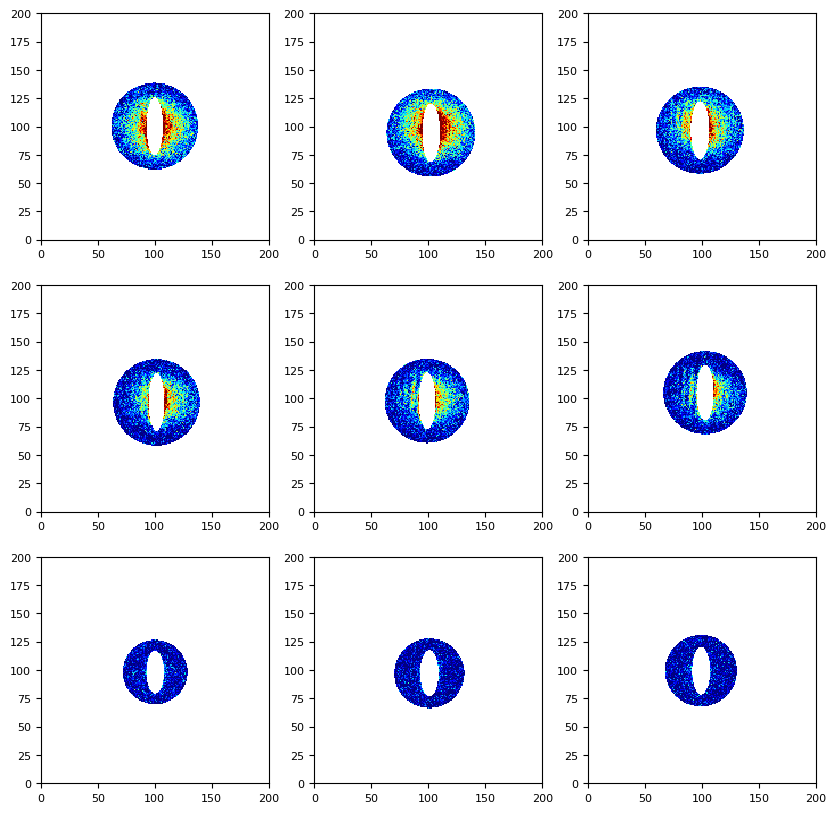

In [87]:
mask = np.zeros(shape)
mask2 = np.zeros(shape)
mask3 = []
fig, ax = plt.subplots(shape[0],shape[1], figsize=(10,10))

for i in range(0, shape[0]):
    temp_arr = []
    for j in range(0, shape[1]):
        print(f'image {i}, {j}')
        arr = []
        bval = result[i][j].best_values
        tf_fit = ThomasFermi_2d(X,Y,centerx=bval['x0_bec'], centery=bval['y0_bec'], amplitude=bval['amp_bec'], sigmax=bval['sigmax_bec'], sigmay=bval['sigmay_bec'])
        tf_fit_2 = ThomasFermi_2d(X,Y,centerx=bval['x0_bec'], centery=bval['y0_bec'], amplitude=bval['amp_bec'], sigmax=1.5 * bval['sigmay_bec'], sigmay=1.5* bval['sigmay_bec'])


        mask[i,j] = np.where(tf_fit > 0, np.nan, cropOD[i,j])
        #mask[i,j] = gaussian_filter(mask[i,j], sigma = 0.4)
        #mask[i,j] = np.where(tf_fit_2 > 0, mask[i,j], np.nan)
        mask2[i,j] = np.where(tf_fit_2 > 0, mask[i,j], np.nan)
        # print(f'max = {np.nanmax(mask[i,j])}, {np.nanmax(mask[i,j]) / np.nanmin(mask[i,j])}')



        check_value = np.nanmean(mask2[i,j]) / (bval["amp_bec"] + bval["amp_th"])

        print(f'check val, {np.nansum(mask2[i,j])}')

        ax[i,j].pcolormesh(mask2[i,j], cmap='jet',vmin=0,vmax=0.5)
        # print(f'mean = {np.nanmean(mask[i,j])}, {np.nanmean(mask2[i,j])}, {np.nanmean(mask[i,j]) / np.nanmean(mask2[i,j])}')
        # print(f'std = {np.nanstd(mask[i,j])}')
        # print()

        # frac = 1
        # temp_res = mask[i,j, round(bval['y0_bec'] - frac * bval['sigmay_bec']) : round(bval['y0_bec'] + frac * bval['sigmay_bec']),:]
        # temp_1d = np.nansum(temp_res, axis=0)
        #
        # print(f'sum = {np.nansum(temp_1d) / np.max(cropOD[i,j])}')
        # print(f'sum = {np.nanmax(temp_1d)/np.max(cropOD[i,j])}')
        #
        # plt.pcolormesh(temp_res, cmap='jet')
        # plt.show()
        # plt.plot(temp_1d)
        # plt.show()


plt.show()

In [184]:
result[1][0]

In [11]:
for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        print(f'image {i}, {j}')
        lmfit.report_fit(result[i][j])

image 0, 0
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 61
    # data points      = 40000
    # variables        = 9
    chi-square         = 247.046739
    reduced chi-square = 0.00617756
    Akaike info crit   = -203464.288
    Bayesian info crit = -203386.918
    R-squared          = 0.77102021
[[Variables]]
    amp_bec:     1.31934618 +/- 0.01009205 (0.76%) (init = 1.824597)
    amp_th:      0.67904205 +/- 0.00727262 (1.07%) (init = 0.8330863)
    x0_bec:      99.8592458 +/- 0.02150100 (0.02%) (init = 99.66897)
    y0_bec:      100.303113 +/- 0.08978268 (0.09%) (init = 99.53103)
    x0_th:       101.408228 +/- 0.10950225 (0.11%) (init = 99.66897)
    y0_th:       99.4582944 +/- 0.12624325 (0.13%) (init = 99.53103)
    sigmax_bec:  7.16636367 +/- 0.04330613 (0.60%) (init = 6.982416)
    sigmay_bec:  25.6141132 +/- 0.14247207 (0.56%) (init = 25)
    sigma_th:    18.0473888 +/- 0.11266887 (0.62%) (init = 20.03728)
[[Correlations]] (unreported correlatio

In [28]:
a = -1
a**(3/2)

(-1.8369701987210297e-16-1j)